In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn import utils as sk_utils
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


2024-04-30 23:58:10.884814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 23:58:10.887024: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 23:58:10.960154: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 23:58:11.373223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 23:58:12.404349: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
train_images_path = '../dataset/data/train/*.jpg'
train_masks_path = '../dataset/label/masks/train/*.png'
val_images_path = '../dataset/data/val/*.jpg'
val_masks_path = '../dataset/label/masks/val/*.png'

In [3]:

model_file = "../checkpoints/deeplab_v1_rusnet_checkpoints_new.keras"
log_file = "../logs/deeplab_v1_rusnet_checkpoints_new.log"

In [4]:
import glob
image_size = (192, 256)

# Load and preprocess the images
def load_image(file_path, is_x=False):
    # Read the image file using tf.io.read_file
    image = tf.io.read_file(file_path)
    # Decode the image into a tensor
    image = tf.image.decode_image(image)
    
    if is_x:
        # Resize the image to the desired size using Lanczos3 method
        image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # Normalize the image
    else:
        # Resize the image to the desired size using 'nearest' method
        image = tf.image.resize(image, image_size, method='nearest', antialias=True)
    return image

In [5]:
# load the training set

# Get the list of image file paths
image_paths = sorted(glob.glob(train_images_path))
mask_paths = sorted(glob.glob(train_masks_path))

# Shuffle the image_paths and mask_paths
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# Create lists to store the loaded and preprocessed images
X_train = []
Y_train = []

# Apply the load_image function to each image path in the dataset
for x, y in zip(image_paths, mask_paths):
    X_train.append(load_image(x, True))
    Y_train.append(load_image(y))
    if len(X_train) % 500 == 0:
        print(len(X_train), 'data points loaded!')
else:
    print(len(X_train), 'data points loaded in total!')

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# 255 is representing unknown objects
Y_train[Y_train == 255] = 19

500 data points loaded!
1000 data points loaded!
1500 data points loaded!
2000 data points loaded!
2500 data points loaded!
3000 data points loaded!
3500 data points loaded!
4000 data points loaded!
4500 data points loaded!
5000 data points loaded!
5500 data points loaded!
6000 data points loaded!
6500 data points loaded!
7000 data points loaded!
7000 data points loaded in total!


In [6]:
# load the validataion set (1000 observations)

# Get the list of image file paths
image_paths = sorted(glob.glob(val_images_path))
mask_paths = sorted(glob.glob(val_masks_path))

# Shuffle the image_paths and mask_paths
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# Create lists to store the loaded and preprocessed images
X_val = []
Y_val = []

# Apply the load_image function to each image path in the dataset
for x, y in zip(image_paths, mask_paths):
    X_val.append(load_image(x, True))
    Y_val.append(load_image(y))
    if len(X_val) == 500:
        print(len(X_val), 'data points loaded!')
else:
    print(len(X_val), 'data points loaded in total!')

# Convert the lists to NumPy arrays
X_val = np.array(X_val)
Y_val = np.array(Y_val)
# 255 is representing unknown objects
Y_val[Y_val == 255] = 19

500 data points loaded!
1000 data points loaded in total!


In [7]:
print('X train:', X_train.shape)
print('Y train:', Y_train.shape)
print('X val:', X_val.shape)
print('Y val:', Y_val.shape)

X train: (7000, 192, 256, 3)
Y train: (7000, 192, 256, 1)
X val: (1000, 192, 256, 3)
Y val: (1000, 192, 256, 1)


In [8]:
# Utils
import numpy as np
import matplotlib.pyplot as plt

color_dict = {
    0: (0.7, 0.7, 0.7),     # road - gray
    1:  (0.9, 0.9, 0.2),     # sidewalk - light yellow
    2: (1.0, 0.4980392156862745, 0.054901960784313725),
    3: (1.0, 0.7333333333333333, 0.47058823529411764),
    4: (0.8, 0.5, 0.1),  # Fence - rust orange
    5: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    6: (0.325, 0.196, 0.361),
    7: (1.0, 0.596078431372549, 0.5882352941176471),
    8:  (0.2, 0.6, 0.2),     # vegetation - green
    9: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
    10: (0.5, 0.7, 1.0),     # sky - light blue
    11: (1.0, 0.0, 0.0), # person - red
    12: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    13: (0.0, 0.0, 1.0),  # Car - blue
    14: (0.0, 0.0, 1.0),  # Track - blue
    15: (0.0, 0.0, 1.0),  # Bus - blue
    16: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    17: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    18: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    19: (0, 0, 0) # unknown - black
}

def colorize_image(image, color_dict):
    # remove the extra dimension
    image = np.squeeze(image)
    # Generate the colored image using the color dictionary
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))

    for pixel_value, color in color_dict.items():
        colored_image[image == pixel_value] = color

    # Convert the image to 8-bit unsigned integer
    colored_image = (colored_image * 255).astype(np.uint8)

    return colored_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


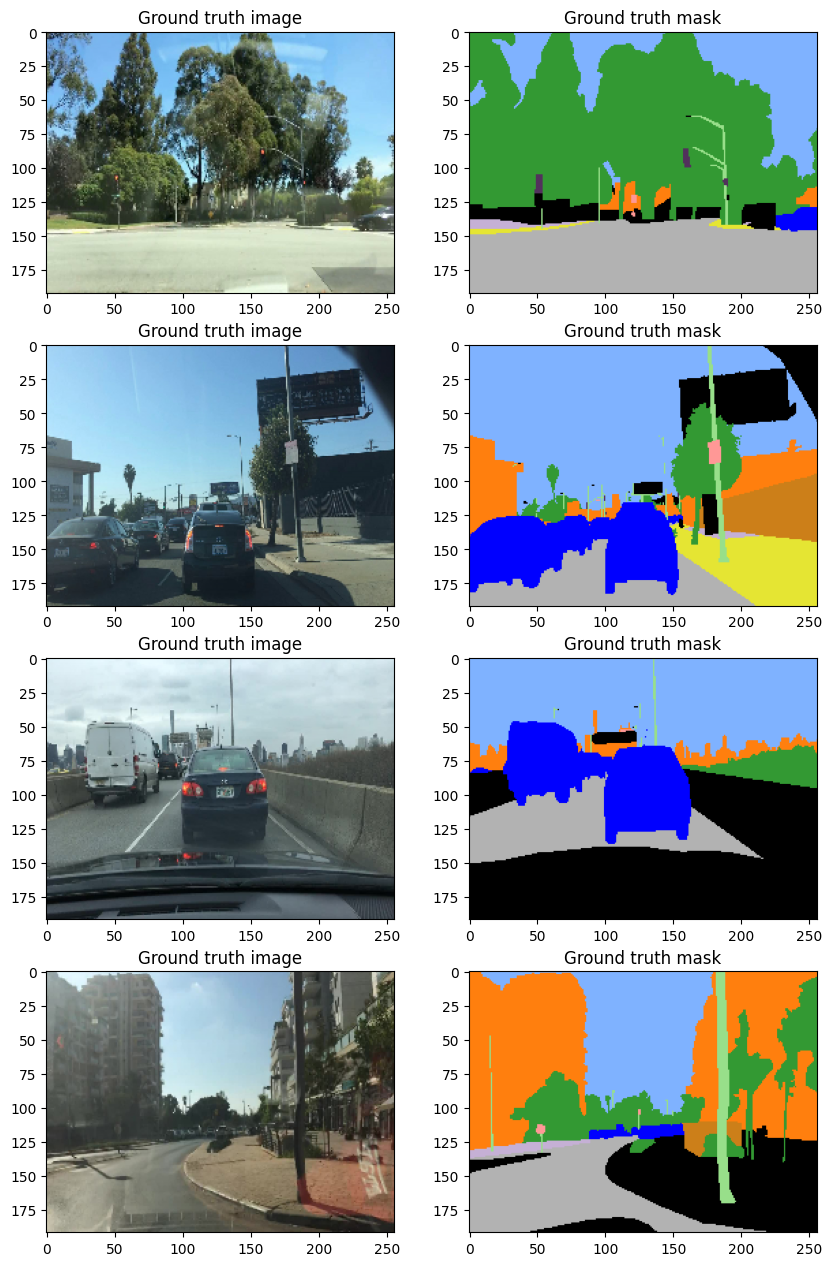

In [9]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Ground truth mask')
    index += 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


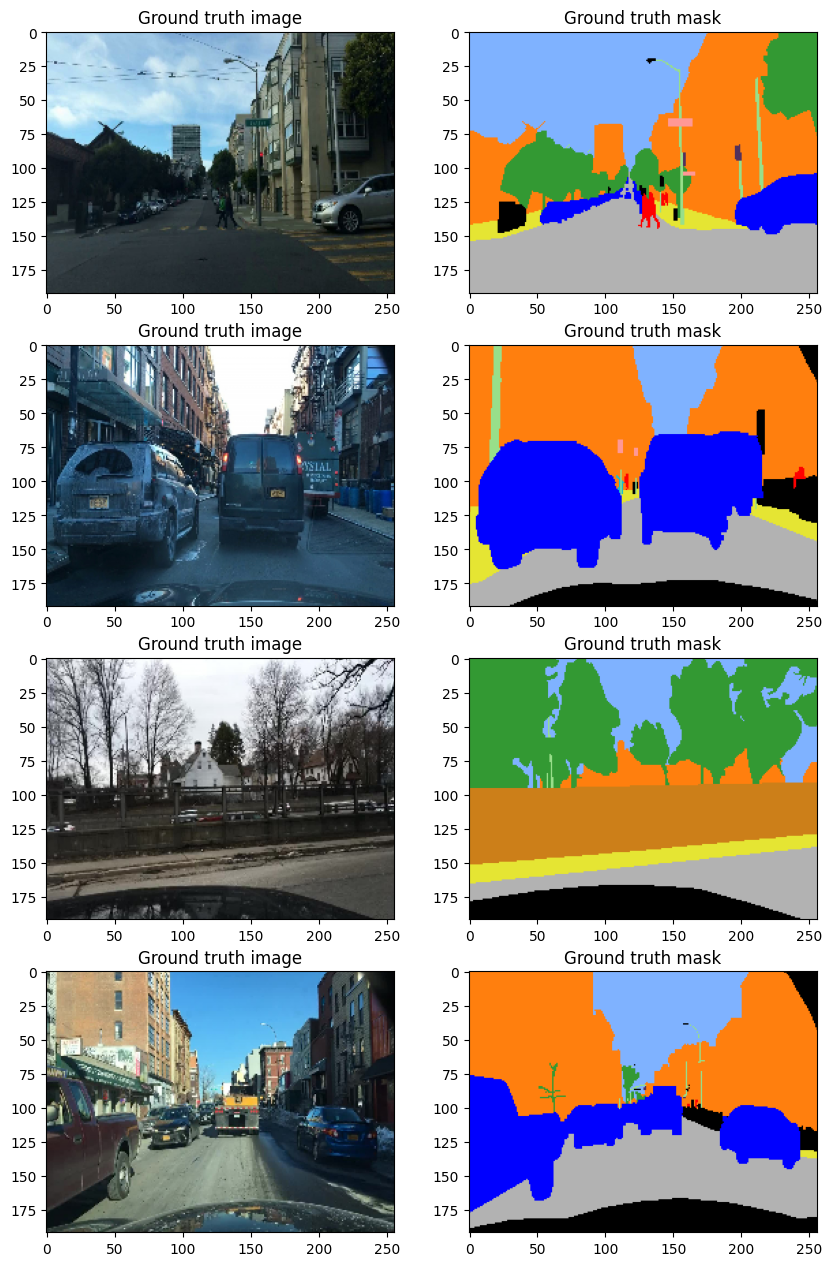

In [10]:
# visualize some samples from the validation set
plt.figure(figsize=(10, 40))
s, e = 10, 14
index = 1

for i, j in zip(X_val[s:e], Y_val[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Ground truth mask')
    index += 2

In [11]:
# free the RAM by collecting the garbage
import gc
gc.collect()

47686

In [12]:
import tensorflow.keras as keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from keras.models import Model
from tensorflow.keras import layers, models

from tensorflow.keras.applications import ResNet50

# --- Hyperparameters ---
input_shape = (192, 256, 3) 
num_classes = 20  
output_stride = 16  

def load_rusnet(weights,include_top,input_tensor):
    model = ResNet50(weights=weights, include_top=include_top, input_tensor=input_tensor)
    return model

# --- Backbone: RusNet ---
def modified_rusnet(input_tensor):
    rusnet = load_rusnet(weights='imagenet', include_top=False, input_tensor=input_tensor)  # Call the function

    # Assuming RusNet might need these changes 
    for layer in rusnet.layers[:-4]:
        layer.trainable = False  # Optionally freeze early layers
    rusnet.layers[-4].strides = (1, 1)  # Adjust if needed for output_stride

    # Adapt dilation rates if needed 
    for layer in rusnet.layers[-3:]:
          layer.dilation_rate = (2, 2) if output_stride == 8 else (1, 1) 

    return rusnet.output

# --- Atrous Spatial Pyramid Pooling (ASPP) ---
def ASPP(input_tensor):
    rates = [1, 6, 12, 18]  # Common dilation rates

    features = []

    # 1x1 convolution branch
    b0 = layers.Conv2D(256, 1, activation='relu')(input_tensor)
    features.append(b0)

    # Atrous convolutions with different dilation rates
    for rate in rates:
        b = layers.Conv2D(256, 3, dilation_rate=rate, activation='relu', padding='same')(input_tensor)
        features.append(b)

    x = layers.Concatenate()(features)
    x = layers.Conv2D(256, 1, activation='relu')(x) 
    return x

# --- Decoder --- 
def decoder(input_tensor):
    x = layers.UpSampling2D(size=(2, 2))(input_tensor)  
    x = layers.UpSampling2D(size=(2, 2))(x) 
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.UpSampling2D(size=(2, 2))(x)# One more upsampling step
    return x

# --- Complete Model ---
def DeepLabv1(input_size=(*image_size,3)):
    inputs = Input(input_size)

    backbone_features = modified_rusnet(inputs)
    aspp_output = ASPP(backbone_features)
    output = decoder(aspp_output)
    output = layers.Conv2D(num_classes, 1, activation='softmax')(output)

    return models.Model(inputs, output)

model = DeepLabv1()



In [13]:
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 198, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 96, 128,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 96, 128,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 96, 128,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 98, 130,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 48, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 48, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 48, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 48, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 48, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 48, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 43,320,724 (165.26 MB)

 Trainable params: 20,787,732 (79.30 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [14]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

In [15]:
# train the model
initial_epoch = 95
epochs = 100
batch_size = 16

model.fit(
    X_train,
    Y_train,
    initial_epoch=initial_epoch,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 96/100


2024-05-01 00:01:23.588342: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


438/438 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - accuracy: 0.4788 - loss: 1.5505 - learning_rate: 1.0000e-04
Epoch 97/100


/home/ghostrix/AI/venv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/home/ghostrix/AI/venv/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/home/ghostrix/AI/venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1017s 2s/step - accuracy: 0.5534 - loss: 1.3204 - learning_rate: 1.0000e-04
Epoch 98/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.5674 - loss: 1.2819 - learning_rate: 1.0000e-04
Epoch 99/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.5800 - loss: 1.2472 - learning_rate: 1.0000e-04
Epoch 100/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.5898 - loss: 1.2207 - learning_rate: 1.0000e-04


In [16]:
# save the model
model.save('./models/deeplab_v1_rusnet_checkpoints_new.h5')
tf.keras.models.save_model(model, 'models/deeplab_v1_rusnet_checkpoints_new.keras')

In [17]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=-1).reshape(-1, *image_size, 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step


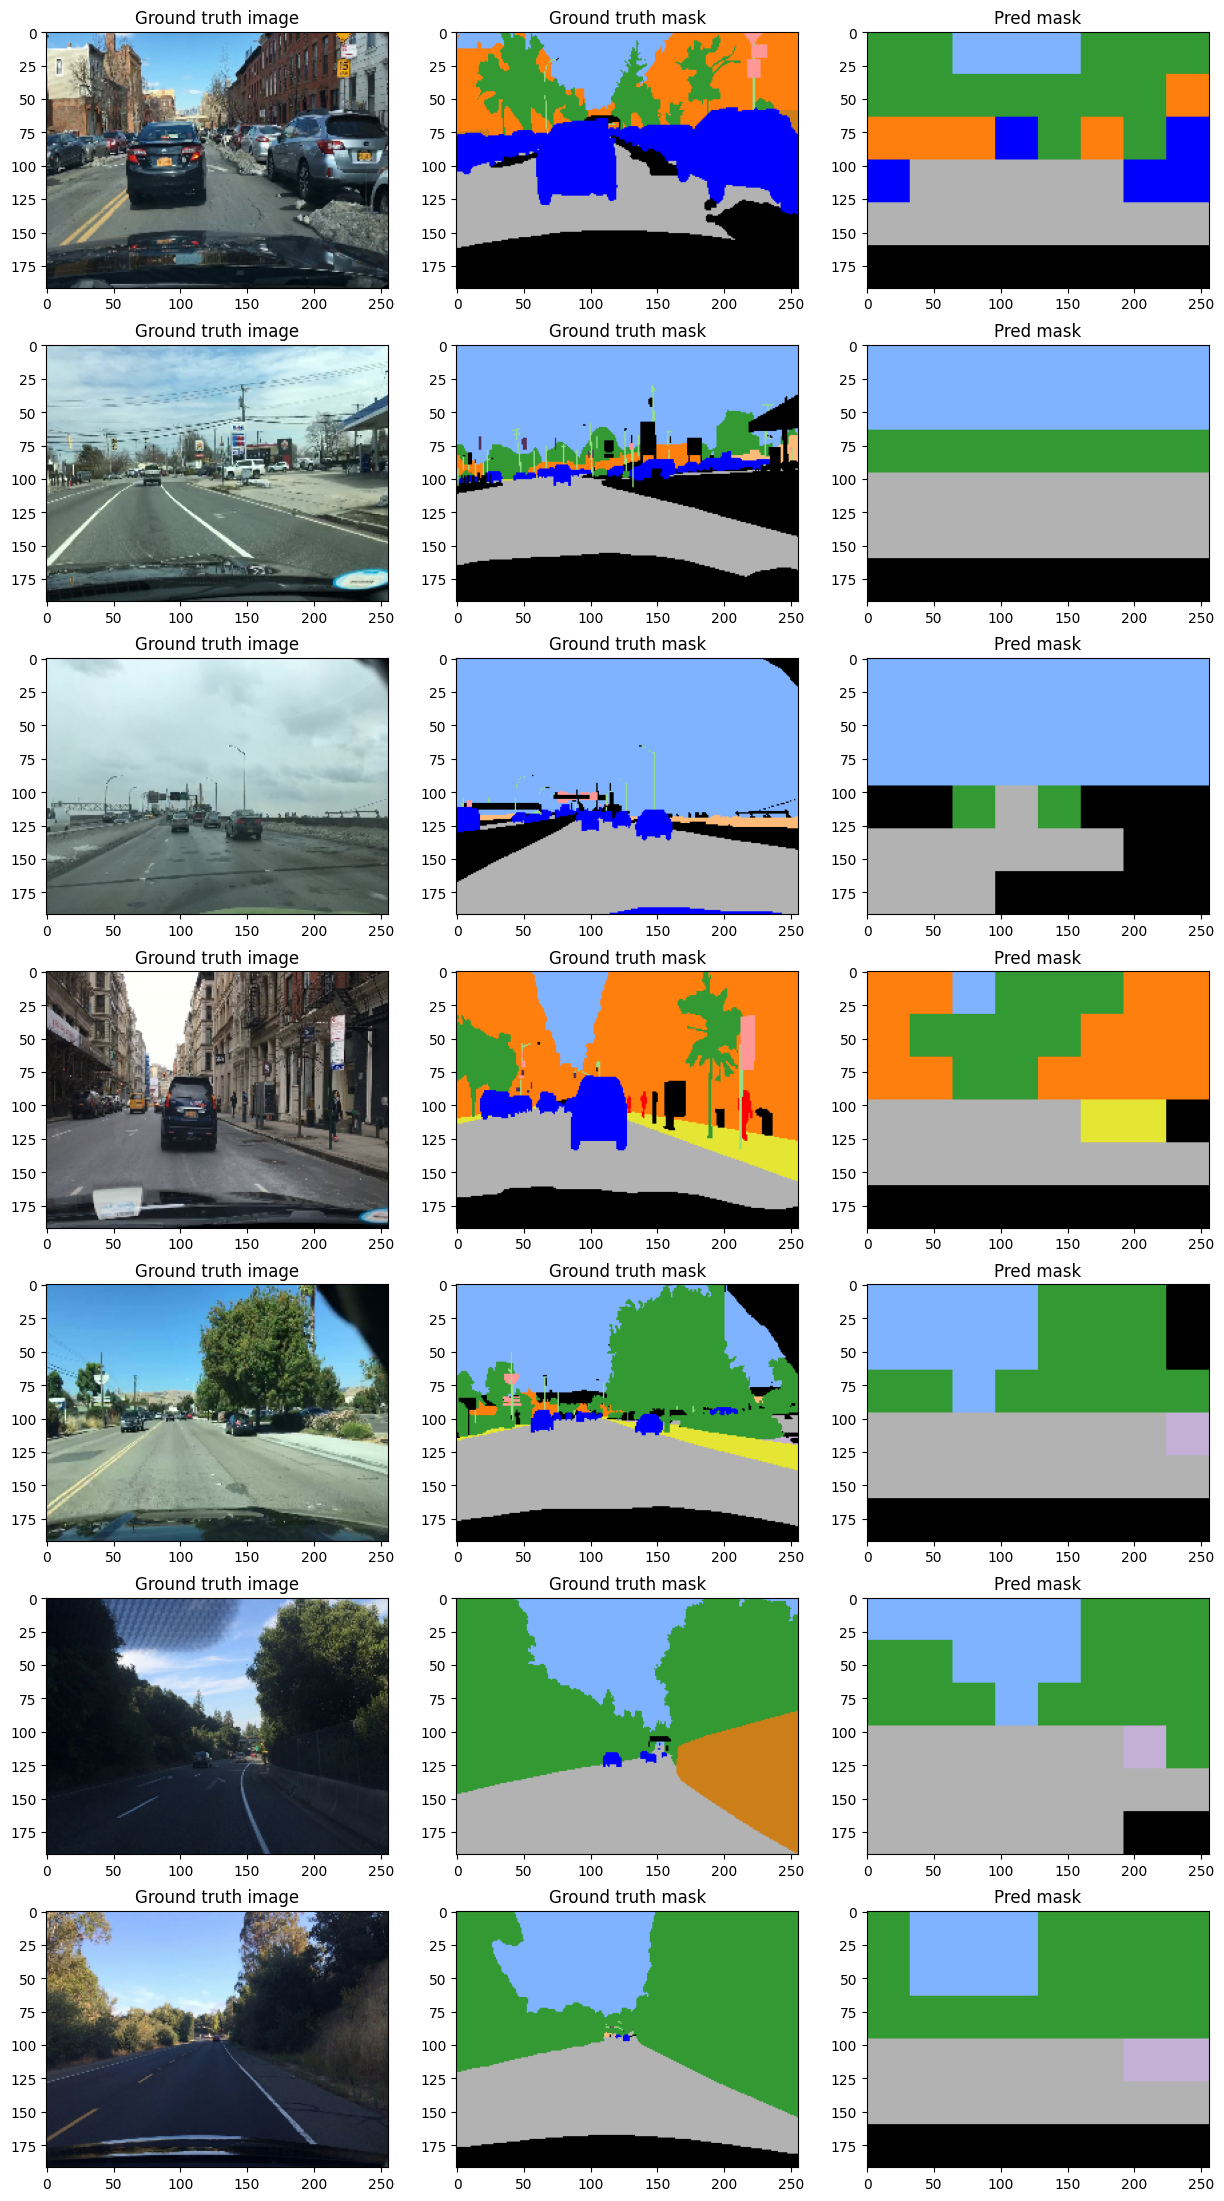

In [18]:
import cv2
# visualize some results from the validation set.
plt.figure(figsize=(15, 40))
s, e = 1, 8
index = 1

for i, j, k in zip(X_val[s:e], Y_pred[s:e], Y_val[s:e]):
    
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.png', j)
    cv2.imwrite(f'./out/ground-{index}.png', k)
    
    plt.subplot(10, 3, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 3, index+1)
    plt.imshow(colorize_image(k, color_dict))
    plt.title('Ground truth mask')
    
    plt.subplot(10, 3, index+2)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Pred mask')
    index += 3

In [20]:
from tensorflow.keras.metrics import MeanIoU, Accuracy

num_classes = 20

def compute_metrics(gt_masks, pred_masks):
    # Reshape the masks to (batch_size, height, width)
    gt_masks_reshaped = tf.reshape(gt_masks, [-1, tf.shape(gt_masks)[-1]])
    pred_masks_reshaped = tf.reshape(pred_masks, [-1, tf.shape(pred_masks)[-1]])

    # Compute accuracy
    accuracy_metric = Accuracy()
    accuracy_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)
    accuracy = accuracy_metric.result().numpy()

    # Compute mean IoU
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)
    miou = iou_metric.result().numpy()

    return accuracy, miou


accuracy, miou = compute_metrics(Y_val, Y_pred)

# Print the metric values
print("Accuracy:", accuracy)
print("Mean IoU:", miou)

Accuracy: 0.5742547
Mean IoU: 0.122504495
